In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

In [ ]:
random.seed(1)

In [ ]:
def update_loc_del():
  everytime_dis = 0
  #for all deliveries, update
  for k in range(len(Map_del)):
    if Way[k] != []:
      # if the delivery is already at seller at begining
      step_next = Way[k][0]
      if Map_del[0][k] == Map['x'][step_next] and Map_del[1][k] == Map['y'][step_next] and step_next >= len(Map_cus):
        del(Way[k][0])
        
    if Way[k] != []:
      # find loc of next step
      step_next = Way[k][0]
      dx1 = Map['x'][step_next]-Map_del[0][k]
      dy1 = Map['y'][step_next]-Map_del[1][k]

      #print("next_xy",Map['x'][step_next],Map['y'][step_next])
      #print("now_xy",Map_del[0][k],Map_del[1][k])

      sin_theta = dy1/np.sqrt(dx1*dx1+dy1*dy1)
      cos_theta = dx1/np.sqrt(dx1*dx1+dy1*dy1)
      ## if achieve corner
      if abs(sin_theta*speed) > abs(dy1) or abs(cos_theta*speed) > abs(dx1):

        #print("encounter corner*******")

        # if not have next_next
        if len(Way[k]) <= 1:
          x_new = Map['x'][step_next]
          y_new = Map['y'][step_next]
          everytime_dis += np.sqrt((Map_del[0][k]-x_new)**2+(Map_del[1][k]-y_new)**2)

        # if have next_next
        else:
          if sin_theta !=0:
            t0 = dy1/(sin_theta*speed)
          else:
            t0 = dx1/(cos_theta*speed)
          t1 = 1-t0
          #print("t1: ", t1)
          step_next_next = Way[k][1]
          #print("next", Way[k][0], "x", Map['x'][Way[k][0]], "y", Map['y'][Way[k][0]])
          #print("next_next", Way[k][1], "x", Map['x'][Way[k][1]], "y", Map['y'][Way[k][1]])

          dx2 = Map['x'][step_next_next] - Map['x'][step_next]
          dy2 = Map['y'][step_next_next] - Map['y'][step_next]
          sin_beta = dy2/np.sqrt(dx2*dx2+dy2*dy2)
          cos_beta = dx2/np.sqrt(dx2*dx2+dy2*dy2)
          x_new = Map['x'][step_next] + t1*speed*cos_beta
          y_new = Map['y'][step_next] + t1*speed*sin_beta
        
          if x_new != Map['x'][step_next] or y_new != Map['y'][step_next]:
            #print("order",Order[k])
            del(Way[k][0])
            Path[k].append([Map['x'][step_next],Map['y'][step_next]])
            if step_next < len(Map_cus):
              Num_orders[k] -= len(Order[k][step_next])
              del Order[k][step_next]
            #print("order_new",Order[k])
          
          everytime_dis += np.sqrt((Map_del[0][k]-Map['x'][step_next])**2+(Map_del[1][k]-Map['y'][step_next])**2) + np.sqrt((Map['x'][step_next]-x_new)**2+(Map['y'][step_next]-y_new)**2)
              

      ## if not achieve corner
      else:
        #print("next: ",Way[k][0], Map['x'][Way[k][0]], Map['y'][Way[k][0]])
        x_new = Map_del[0][k] + 1*speed*cos_theta
        y_new = Map_del[1][k] + 1*speed*sin_theta
      
      everytime_dis += np.sqrt((Map_del[0][k]-x_new)**2+(Map_del[1][k]-y_new)**2)

      if x_new == Map['x'][step_next] and y_new == Map['y'][step_next]:
        #print(Way[k])
        #print("new_xy",x_new,y_new)
        #print("next_step",Map['x'][step_next],Map['y'][step_next] )
        del(Way[k][0])
        if step_next < len(Map_cus):
          Num_orders[k] -= len(Order[k][step_next])
          del Order[k][step_next]

      #update
      Map_del[0][k]=x_new
      Map_del[1][k]=y_new

      #print("k",k,"loc: ",x_new,y_new)

    Path[k].append([Map_del[0][k],Map_del[1][k]])

  return everytime_dis

  

In [ ]:
def Obj_fun(temp_list_way, list_order):

    distance = 0
    time = [0]
    for s in range(1,len(temp_list_way)):
      # find the location of this step and previous step
      step_id = temp_list_way[s]
      p_step_id = temp_list_way[s-1]

      loc_step_x = Map['x'][step_id]
      loc_step_y = Map['y'][step_id]
      loc_p_step_x = Map['x'][p_step_id]
      loc_p_step_y = Map['y'][p_step_id]

      # find the sum of the distance
      distance_step = np.sqrt( (loc_step_x-loc_p_step_x)**2 + (loc_step_y-loc_p_step_y)**2 )
      distance = distance + distance_step
      # find the time
      time.append(distance/speed)

    # find sum of over time
    sum_overtime = 0
    kt =0
    for i in range(len(temp_list_way)):
      step_id = temp_list_way[i]
      if step_id < len(Map_cus):
        #print("way: ",temp_list_way)
        #print("order", list_order)
        #print("step_id",step_id)
        for order_time in list_order[step_id]:
          sum_overtime += max(time[i]-order_time,0)
          kt += 1

    return distance + sum_overtime
    


In [ ]:
def Find_best_way(list_way, cus, sel, list_order):
    cus_id = cus
    sel_id = sel+len(Map_cus)

    min_obj = 1000000
    for start in range(len(list_way)+1):
      temp_list_sel = list_way[0:start]+[sel_id]+list_way[start:]
      for end in range(start+1, len(temp_list_sel)+1):
        temp_list_sel_cus = temp_list_sel[0:end]+[cus_id]+temp_list_sel[end:]
        obj = Obj_fun(temp_list_sel_cus, list_order)
        if obj < min_obj:
          min_obj = obj
          min_obj_list = temp_list_sel_cus
    
    #print(min_obj_list)
    min_obj_nodup = []
    for i in min_obj_list: 
      if not i in min_obj_nodup: 
        min_obj_nodup.append(i) 
    #print(min_obj_nodup)

    return min_obj_nodup


In [ ]:
def calculate_new_overtime(t):
  num_new_overtime = 0
  for k_order in Order:
    for time_list in k_order.values():
      for time in time_list:
        if time == t:
          #print(k_order)
          num_new_overtime +=1
  return num_new_overtime


In [ ]:
def method1(capacity):
  #########Method 1#######
  wait_list = []
  new_num_order_canceled = 0
  sum_num_order_canceled = 0
  sum_num_overtime = 0
  num_order_lower = 20
  num_order_upper = 40
  sum_dis = 0

  for t in range(0,180):
    print("##########",t,"############")
    # update the location of all deliveries every minute
    everytime_dis = update_loc_del()
    sum_dis += everytime_dis

    # find the number of new overtime orders
    num_new_overtime = calculate_new_overtime(t)
    sum_num_overtime += num_new_overtime

    # arrange the orders in the waitlist
    if wait_list != []:
      new_num_order_canceled = 0
      for order in wait_list:
        # if wait more than 10 min, cancel
        if t - order[2] >=10:
          wait_list.remove(order)
          new_num_order_canceled +=1
          continue

        loc_sel_x = Map_sel[0][order[1]]
        loc_sel_y = Map_sel[1][order[1]]

        num_min =-999
        dis_min = 100000
        for k in range(len(Map_del)):
          if Num_orders[k] < capacity:
            #print(capacity)
            dis = np.sqrt((Map_del[0][k] - loc_sel_x)**2 + (Map_del[1][k] - loc_sel_y)**2)
            if dis < dis_min:
              # the closest distance
              dis_min = dis
              # the number of the closest delivery
              num_min = k

        if num_min != -999:
          # give the order to the closest delivery
          Num_orders[num_min] += 1
          if order[0] in Order[num_min].keys():
            Order[num_min][order[0]].append(order[2]+45)
          else:
            Order[num_min][order[0]] = [order[2]+45]
        
          wait_list.remove(order)
          # Find the best way
          new_way = Find_best_way(Way[num_min],order[0],order[1],Order[num_min])
          Way[num_min] = new_way
    
      #print(new_num_order_canceled)
      sum_num_order_canceled += new_num_order_canceled

    # decide how many orders generated in this minute
    punish = int(1 *new_num_order_canceled + 0.5*num_new_overtime)
    #print("pubish",punish)
    num_order = random.randint(num_order_lower - punish , num_order_upper - punish)
    #print("num_order",num_order)
    if num_order <0:
      print("no order!!")
      continue
    for order in range(num_order):
      # decide the customer and seller of the order
      cus = random.randint(0,len(Map_cus)-1)
      sel = random.randint(0,len(Map_sel)-1)
      # find the location of customer and seller
      loc_cus_x = Map_cus[0][cus]
      loc_cus_y = Map_cus[1][cus]
      loc_sel_x = Map_sel[0][sel]
      loc_sel_y = Map_sel[1][sel]

      # find the closest delivery to the seller
      dis_min = 10000000
      num_min = -999
      for k in range(len(Map_del)):
        if Num_orders[k] < capacity:
          #print(capacity)
          dis = np.sqrt((Map_del[0][k] - loc_sel_x)**2 + (Map_del[1][k] - loc_sel_y)**2)
          if dis < dis_min:
            # the closest distance
            dis_min = dis
            # the number of the closest delivery
            num_min = k

      #print("to delivery",num_min)

      if num_min == -999:
        wait_list.append([cus, sel, t])

      else:
        # give the order to the closest delivery
        Num_orders[num_min] +=1
        if cus in Order[num_min].keys():
          Order[num_min][cus].append(t+45)
        else:
          Order[num_min][cus] = [t+45]

        # Find the best way
        new_way = Find_best_way(Way[num_min],cus,sel,Order[num_min])
        Way[num_min] = new_way
        #print(new_way)

  return sum_num_overtime, sum_num_order_canceled, sum_dis

In [ ]:
overtime_list_result = []
cancel_list_result = []
rundis_list_result = []

In [ ]:
capacity = 10
for round in range(1):
  Map_cus = pd.DataFrame([[4,4],[11,5],[16,4],[9,6],[10,6],[16,6],[10,8],[15,8],[17,8],[10,9],[11,9],[14,9],[15,9],[18,9],[13,10],[14,10],[18,10],[19,11],[18,11],[9,12],[14,12],[16,12],[9,13],[10,13],[11,14],[12,14],[15,14],[19,14],[20,14],[10,15],[11,15],[12,15],[13,15],[16,15],[19,15],[21,15],[10,16],[12,16],[15,16],[19,16],[20,16],[20,17],[21,17],[11,18],[12,18],[21,18],[19,20],[14,21],[17,23],[15,24],[11,27]])
  Map_sel = pd.DataFrame([[8,4],[10,5],[16,8],[12,9],[9,11],[13,11],[17,11],[19,10],[17,15],[9,16],[17,16],[21,16],[19,17],[12,19],[18,19]])
  Map = pd.concat([Map_cus,Map_sel]).reset_index()
  Map.columns = ['num','x','y']
  speed = 1

  random.seed(1)
  Map_del = []
  Way = []
  Order = []
  Num_orders = []
  Path = []
  for i in range(100):
    Map_del.append([float(random.randint(0,22)),float(random.randint(0,29))])
    Way.append([])
    Order.append({})
    Num_orders.append(0)
    Path.append([])
  Map_del = pd.DataFrame(Map_del)

  overtime_result, cancel_result, rundis_result = method1(capacity)
  overtime_list_result.append(overtime_result)
  cancel_list_result.append(cancel_result)
  rundis_list_result.append(rundis_result)

########## 0 ############
########## 1 ############
########## 2 ############
########## 3 ############
########## 4 ############
########## 5 ############
########## 6 ############
########## 7 ############
########## 8 ############
########## 9 ############
########## 10 ############
########## 11 ############
########## 12 ############
########## 13 ############
########## 14 ############
########## 15 ############
########## 16 ############
########## 17 ############
########## 18 ############
########## 19 ############
########## 20 ############
########## 21 ############
########## 22 ############
########## 23 ############
########## 24 ############
########## 25 ############
########## 26 ############
########## 27 ############
########## 28 ############
########## 29 ############
########## 30 ############
########## 31 ############
########## 32 ############
########## 33 ############
########## 34 ############
########## 35 ############
########## 36 ############
########## 

In [ ]:
print("overtime: ",sum(overtime_list_result)/len(overtime_list_result))
print("cancel: ",sum(cancel_list_result)/len(cancel_list_result))
print("distance: ",sum(rundis_list_result)/len(rundis_list_result))


overtime:  1558.0
cancel:  625.0
distance:  19485.623319199578


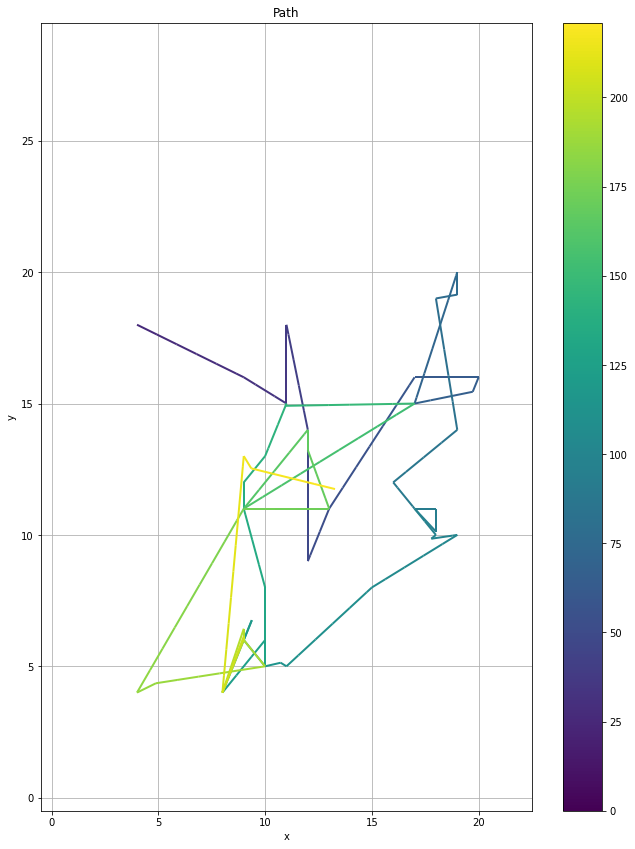

In [ ]:
# Data for plotting
path_data = pd.DataFrame(Path[0])

x=np.array(path_data[0][0])
y=np.array(path_data[1][0])
for i in range(len(path_data)-1):
  x = np.hstack((x,(np.linspace(path_data[0][i], path_data[0][i+1], 1))))
  y = np.hstack((y,(np.linspace(path_data[1][i], path_data[1][i+1], 1))))

color = np.array([i for i in range(len(path_data))])

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, axs = plt.subplots(figsize=(11,14.5))

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(color.min(), color.max())
lc = LineCollection(segments, cmap='viridis', norm=norm)
# Set the values used for colormapping
lc.set_array(color)
lc.set_linewidth(2)

line = axs.add_collection(lc)
fig.colorbar(line, ax=axs)

axs.set_xlim(0-0.5, 22+0.5)
axs.set_ylim(0-0.5, 29+0.5)

axs.set(xlabel='x', ylabel='y', title='Path')
axs.grid()

fig.savefig("method1.png")
plt.show()


In [ ]:
Path[0]

[[4.0, 18.0],
 [4.0, 18.0],
 [4.0, 18.0],
 [4.0, 18.0],
 [4.0, 18.0],
 [4.0, 18.0],
 [4.0, 18.0],
 [4.0, 18.0],
 [4.0, 18.0],
 [4.0, 18.0],
 [4.0, 18.0],
 [4.0, 18.0],
 [4.0, 18.0],
 [4.0, 18.0],
 [4.0, 18.0],
 [4.0, 18.0],
 [4.0, 18.0],
 [4.0, 18.0],
 [4.0, 18.0],
 [4.0, 18.0],
 [4.0, 18.0],
 [4.0, 18.0],
 [4.0, 18.0],
 [4.0, 18.0],
 [4.0, 18.0],
 [4.0, 18.0],
 [4.928476690885259, 17.628609323645897],
 [5.856953381770518, 17.257218647291793],
 [6.785430072655777, 16.88582797093769],
 [7.713906763541036, 16.514437294583587],
 [8.642383454426295, 16.143046618229484],
 [9, 16],
 [9.549925314482575, 15.725037342758712],
 [10.444352505482492, 15.277823747258754],
 [11, 15],
 [11.0, 15.378767215365706],
 [11.0, 16.378767215365706],
 [11.0, 17.378767215365706],
 [11, 18],
 [11.091864543321993, 17.63254182671203],
 [11.334400168358325, 16.662399326566696],
 [11.576935793394659, 15.692256826421364],
 [11.819471418430991, 14.722114326276031],
 [12, 14],
 [12.0, 13.744338410251952],
 [12.0, 12.7